In [129]:
import numpy as np
import matplotlib.pyplot as plt
import enzyme_utils_hpw as utils
import pymc3 as pm
import theano.tensor as tt
from scipy import stats
# import msdanalyzer as msd

In [130]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Since in the dataset we have missing frames, the simple calautoCorr might not be accurate. However, since what we want is just the first autocorrelation for x and dx, the more accurate version of the function can be easily coded out. 

In [131]:
def removeOutLiar(sx, sy, st):
    """detect and remove outliers in the data"""

    zscore_x, zscore_y = np.abs(stats.zscore(sx)), np.abs(stats.zscore(sy))
    outlier_x = np.where(zscore_x >= 2.5)[0]
    outlier_y = np.where(zscore_y >= 2.5)[0]
    all_outlier = list((set(outlier_x).union(set(outlier_y))))
    sx, sy = np.delete(sx, all_outlier), np.delete(sy, all_outlier)
    st = np.delete(st, all_outlier)
    return sx, sy, st

In [132]:
def calAutoCorr(sdx, n_lag): 
    autocorrelation = np.zeros((n_lag, ))
    for i in range(n_lag): 
        shift = i + 1
        correlation = np.corrcoef(sdx[:-shift], 
                                  sdx[shift:])[0, 1]
        autocorrelation[i] = correlation
    return np.insert(autocorrelation, 0, 1)

In [133]:
def autoCorrFirstX(x, dt): 
    
    single_jump_ind = np.where(dt == 1.)[0]
    corr = np.corrcoef(x[single_jump_ind], x[single_jump_ind+1])
    
    return corr[0, 1]

def autoCorrFirstDx(dx, dt): 
    
    single_jump_ind = np.where(dt == 1.)[0][1:]
    corr = np.corrcoef(dx[single_jump_ind], dx[single_jump_ind-1])
    
    return corr[0, 1]

In [134]:
dir_ = 'new_data/transformed_buffer/'
dx, dy, dt, track_info, lookup, track_id = utils.loadRawMinData(dir_, min_length=5, isDx=True)
x, y, t, track_info2, lookup2, track_id2 = utils.loadRawMinData(dir_, min_length=5, isDx=False)

Total 15 files read; Total 813 trajectories (length >= 5) loaded; Total 23096 data points
Total 15 files read; Total 813 trajectories (length >= 5) loaded; Total 23909 data points


In [135]:
min_len = [5, 10, 25, 50, 100]
min_5, min_10, min_25, min_50, min_100 = [], [], [], [], []
min_5_ind, min_10_ind, min_25_ind, min_50_ind, min_100_ind = [], [], [], [], []
min_tot = [[min_5, min_5_ind], [min_10, min_10_ind], 
           [min_25, min_25_ind], [min_50, min_50_ind], [min_100, min_100_ind]]

for j, length in enumerate(track_info): 
    stored = False
    for i in range(len(min_len)-1): 
        if length >= min_len[i] and length < min_len[i+1]: 
#             min_tot[i][0].append(bm_logd[j])
            min_tot[i][1].append(j)
            stored = True
            break
    if stored == False: 
#         min_tot[-1][0].append(bm_logd[j])
        min_tot[-1][1].append(j)

In [136]:
min_25_up = [min_25_ind, min_50_ind, min_100_ind]
min_25_up = np.concatenate(min_25_up)

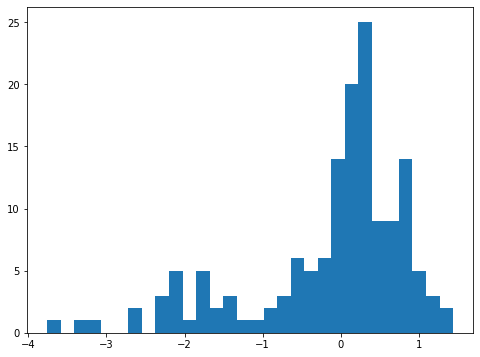

In [137]:
a, b = 0.25, 0.2
map_estimator = np.zeros((len(pass_ind), ))
for i in range(len(pass_ind)):
    
    sx, sy, st = utils.loadSelectTraj(x, y, t, track_info, pass_ind[i], False)
    sx, sy, st = removeOutLiar(sx, sy, st)
    sdx, sdy, sdt = sx[1:]-sx[:-1], sy[1:]-sy[:-1], st[1:]-st[:-1]
    map_estimator[i] = utils.MAP_bm(sdx, sdy, sdt, a, b)

# x = np.linspace(np.log(-4), np.log(4), 1000)
plt.figure(figsize=(8, 6))
plt.hist(np.log(map_estimator), bins=30);
# sns.distplot(np.log(r), hist = False, kde = True, 
#              kde_kws = {'linewidth': 3, 'color':'r', 'ls':'--', 'label':'prior: a=1.1, b=0.8'})
# plt.xticks([])
# plt.yticks([])
# plt.xlim(-5, 5);

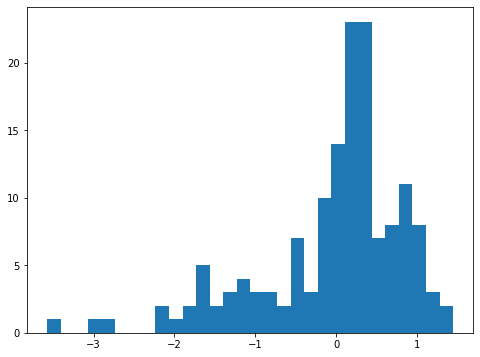

In [278]:
plt.figure(figsize=(8, 6))
plt.hist(np.log(bbb), bins=30);

In [24]:
np.array(pass_ind)[np.where(np.log(np.array(map_estimator)) < -1)[0]]

array([ 23,  92, 111, 126, 410, 440, 491, 593, 646, 745, 780, 656, 742,
       409, 437, 530, 596, 633, 644, 652, 747])

In [179]:
ind = [i for i in range(len(pass_ind))]
dtype = [('log_d', float), ('index', int)]
order = 'log_d'
utils.sort_by_entry([k_mean, ind], dtype, order)

In [296]:
d_mean = stats.mode(trace['D'], axis=0)
k_mean = trace['k'].mean(axis=0)

In [297]:
d_mean = d_mean[0].reshape(149, )

In [171]:
ccc_mean = trace4['D'].mean(axis=0)
ccc = trace4['D']

In [168]:
bbb_mean.shape

(38,)

In [178]:
ccc = np.loadtxt('k_unpool.txt')
k_mean = ccc.mean(axis=0)

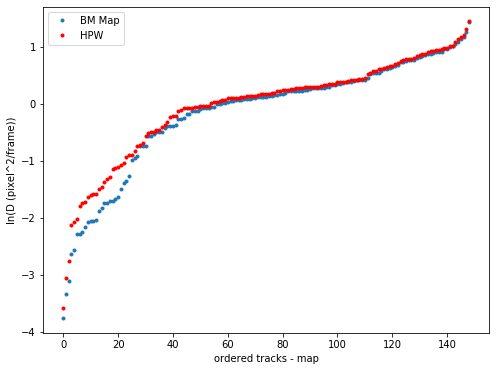

In [17]:
plt.figure(figsize=(8, 6))
plt.plot([i for i in range(len(pass_ind))], np.log(map_estimator), '.', label='BM Map');
plt.plot([i for i in range(len(pass_ind))], np.log(d_mean), '.', c='r', label='HPW');
plt.xlabel('ordered tracks - map')
plt.ylabel('ln(D (pixel^2/frame))')
plt.legend();

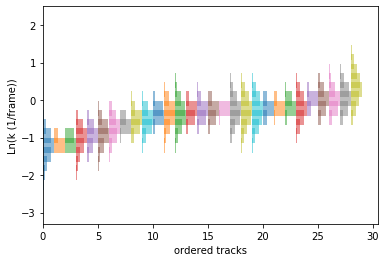

In [188]:
number_of_bins = 30
data_set_logD =[np.log(ccc[:, i]) for i in ind[120:]] 
logD_range = (np.min(data_set_logD), np.max(data_set_logD))

binned_logD = [
    np.histogram(d, range=logD_range, bins=number_of_bins)[0]
    for d in data_set_logD
]

logD_edges = np.linspace(logD_range[0], logD_range[1], number_of_bins+1)
logD_centers = 0.5 * (logD_edges + np.roll(logD_edges, 1))[:-1]

lefts = [i for i in range(len(ind))]

fig, ax = plt.subplots()
for i, data in enumerate(binned_logD): 
    data = data/data.max()
    ax.barh(logD_centers, data, height=0.4, left=lefts[i], alpha=0.5)


plt.xlabel('ordered tracks')
plt.ylabel('Ln(k (1/frame))')
plt.ylim(-3.3, 2.5)
plt.show()


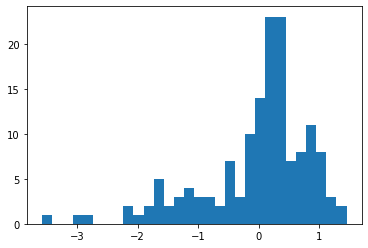

In [331]:
plt.hist(np.log(bbb), bins=30);

In [143]:
np.where(np.log(d_mean) <= -1.5)[0]

array([ 76,  97, 125, 129, 133], dtype=int64)

In [29]:
def MAP_hpw(sx, sy, dt):
    
    
    lam = np.log(np.sum(sy[1:] ** 2 + sx[1:] ** 2) / \
                 np.sum(sy[1:] * sy[:-1] + sx[1:] * sx[:-1]))/dt

    I = 1 - np.exp(-2 * lam * dt)
    D = lam * (np.sum((sy[1:] - sy[:-1] * np.exp(-lam * dt)) ** 2 +
                      (sx[1:] - sx[:-1] * np.exp(-lam * dt)) ** 2) / I / 2 / (len(sy) - 1))

    return D, lam

In [12]:
def removeOutLiar(sx, sy, st):
    """detect and remove outliers in the data"""

    zscore_x, zscore_y = np.abs(stats.zscore(sx)), np.abs(stats.zscore(sy))
    outlier_x = np.where(zscore_x >= 2.5)[0]
    outlier_y = np.where(zscore_y >= 2.5)[0]
    all_outlier = list((set(outlier_x).union(set(outlier_y))))
    sx, sy = np.delete(sx, all_outlier), np.delete(sy, all_outlier)
    st = np.delete(st, all_outlier)
    return sx, sy, st

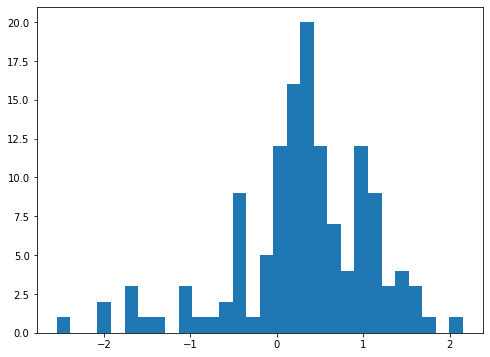

In [139]:
map_estimator2 = np.zeros((len(pass_ind), ))
for i in range(len(pass_ind)): 
    sx, sy, st = utils.loadSelectTraj(x, y, t, track_info, pass_ind[i], False)
    sx, sy, st = removeOutLiar(sx, sy, st)
    map_estimator2[i], _ = MAP_hpw(sy-sy.mean(), sx-sx.mean(), 1)

plt.figure(figsize=(8, 6))
plt.hist(np.log(map_estimator2), bins=30);
# sns.distplot(np.log(r), hist = False, kde = True, 
#              kde_kws = {'linewidth': 3, 'color':'r', 'ls':'--', 'label':'prior: a=1.1, b=0.8'})
# plt.xticks([])
# plt.yticks([])
# plt.xlim(-5, 5);

In [138]:
dx_stats, x_stats = np.zeros((len(min_25_up), )), np.zeros((len(min_25_up), ))
dy_stats, y_stats = np.zeros((len(min_25_up), )), np.zeros((len(min_25_up), ))

for i in range(len(min_25_up)): 
    
    sx, sy, st = utils.loadSelectTraj(x, y, t, track_info, min_25_up[i], False)
    sx, sy, st = removeOutLiar(sx, sy, st)
    sdx, sdy, sdt = sx[1:]-sx[:-1], sy[1:]-sy[:-1], st[1:]-st[:-1]
    
    x_stats[i], dx_stats[i] = autoCorrFirstX(sx, sdt), autoCorrFirstDx(sdx, sdt)
    y_stats[i], dy_stats[i] = autoCorrFirstX(sy, sdt), autoCorrFirstDx(sdy, sdt)

In [139]:
pass_ind = []
not_pass_ind = []
for i in range(len(min_25_up)): 
    if x_stats[i] >= 0.3 or y_stats[i] >= 0.3: 
#         if dx_stats[i] >= -0.4 or dy_stats[i] >= -0.4: 
        if min_25_up[i] == 790 or min_25_up[i] == 265: 
            continue
        pass_ind.append(min_25_up[i])
        continue
    not_pass_ind.append(min_25_up[i])

In [145]:
new_x, new_y, new_t = [], [], []
new_dx, new_dy, new_dt = [], [], []
new_lookup = []

for i in range(len(not_pass_ind)): 
    sx, sy, st = utils.loadSelectTraj(x, y, t, track_info, not_pass_ind[i], False)
    sx, sy, st = removeOutLiar(sx, sy, st)
    new_x.append((sx-sx.mean())[:-1])
    new_y.append((sy-sy.mean())[:-1])
    new_t.append((st-st.mean())[:-1])
    
    new_dx.append(sx[1:]-sx[:-1])
    new_dy.append(sy[1:]-sy[:-1])
    new_dt.append(st[1:]-st[:-1])
    
    new_lookup.append(i*np.ones((len(sx[1:]-sx[:-1]), )))

In [146]:
new_x = np.concatenate(new_x)
new_y = np.concatenate(new_y)
new_t = np.concatenate(new_t)

new_dx = np.concatenate(new_dx)
new_dy = np.concatenate(new_dy)
new_dt = np.concatenate(new_dt)

new_lookup = (np.concatenate(new_lookup)).astype('int')

In [147]:
len(pass_ind)

149

In [148]:
model4 = pm.Model()

with model4: 

#     mu_d = pm.Normal('mu_d', mu=0, sd=1)
#     sig_d = pm.Lognormal('sig_d', mu=0, sigma=1)
    
    D = pm.Lognormal('D', -3, 2, shape=len(not_pass_ind))
    k = pm.Lognormal('k', -2, 1, shape=len(not_pass_ind))
    D_, k_ = D[new_lookup], k[new_lookup]

    
    mean_x = (-(new_x)) * (1-tt.exp(-k_*new_dt))
    mean_y = (-(new_y)) * (1-tt.exp(-k_*new_dt))
    std = tt.sqrt(D_*(1-tt.exp(-2*k_*new_dt))/k_)

    like_x = pm.Normal('like_x', mu=mean_x, sd=std, observed=new_dx)
    like_y = pm.Normal('like_y', mu=mean_y, sd=std, observed=new_dy)

In [149]:
with model4:
    trace4 = pm.sample(2000, tune=2000, chains=2, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [k, D]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 602 seconds.


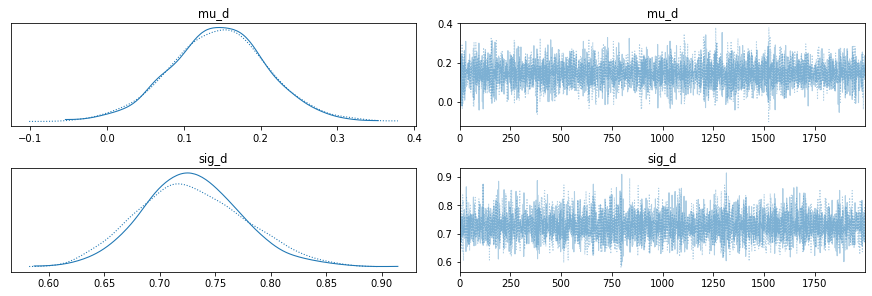

In [68]:
pm.traceplot(trace, var_names=['mu_d', 'sig_d']);

In [324]:
np.savetxt('d_unpool.txt', trace4['D'])
np.savetxt('k_unpool.txt', trace4['k'])

(-0.6149261366536652, -0.3902707083001206)

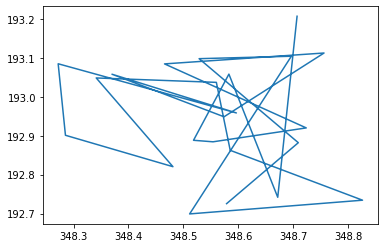

In [152]:
sx, sy, st = utils.loadSelectTraj(x, y, t, track_info, not_pass_ind[0], False)
sx, sy, st = removeOutLiar(sx, sy, st)
sdx, sdy, sdt = sx[1:]-sx[:-1], sy[1:]-sy[:-1], st[1:]-st[:-1]
plt.plot(sx, sy);
autoCorrFirstDx(sdx, sdt), autoCorrFirstDx(sdy, sdt)

In [153]:
autoCorrFirstX(sx, sdt), autoCorrFirstX(sy, sdt)

(0.19085173000846872, -0.04389854877916336)

In [311]:
MAP_hpw(sy-sy.mean(), sx-sx.mean(), 1)

(0.6424218789867466, 1.1248675872232734)

In [154]:
utils.MAP_bm(sdx, sdy, sdt, a, b)

0.027016003948041746

In [155]:
model = pm.Model()

with model: 
    
#     D = pm.Lognormal('D', 0, 1)
#     k = pm.Lognormal('k', 2, 1)

    D = pm.Lognormal('D', -3, 2)
    k = pm.Lognormal('k', -2, 1)
    
    mean_x = (0 - (sx-sx.mean())[:-1])*(1-tt.exp(-k*sdt))
    mean_y = (0 - (sy-sy.mean())[:-1])*(1-tt.exp(-k*sdt))
    std = tt.sqrt(D*(1-tt.exp(-2*k*sdt))/k)

    like_x = pm.Normal('like_x', mu=mean_x, sd=std, observed=sdx)
    like_y = pm.Normal('like_y', mu=mean_y, sd=std, observed=sdy)

In [156]:
map_est = pm.find_MAP(model=model)
map_est

{'D_log__': array(-3.6870279),
 'k_log__': array(0.16691807),
 'D': array(0.02504633),
 'k': array(1.18165745)}

In [157]:
with model:
    trace = pm.sample(2000, tune=2000, chains=2, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [k, D]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
The number of effective samples is smaller than 25% for some parameters.


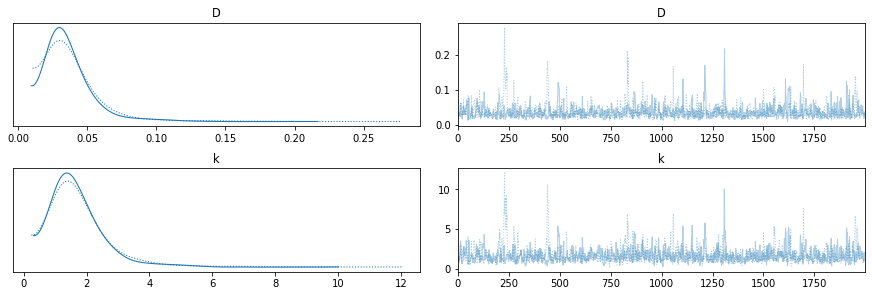

In [158]:
pm.traceplot(trace);

In [23]:
def manyplots_real(row, column, min_indx, filename=None, min_length=None): 
    """
    plots multiple trajecotries according to inout index
    """
    count = 0
    outer_break = False
    fig, axes = plt.subplots(row, column, figsize=(15, 15*(row/column)))
    
#     # calcuate max interval for each trajectory
#     max_interval = computeInterval(min_indx)
    ran = 5
    for i in range(row): 
        if outer_break: 
            break
        for j in range(column): 
            if count == len(min_indx): 
                outer_break = True
                break
            sx, sy, st = utils.loadSelectTraj(x, y, t, track_info, min_indx[count], False)
            sx, sy, st = removeOutLiar(sx, sy, st)
            
            if min_length is None: 
                axes[i, j].plot(sx, sy,'.-')
            else: 
                axes[i, j].plot(sx, sy,'.-', label='logD = ' + str(min_length[count])[:4])
                axes[i, j].legend()
            axes[i, j].set_title(str(min_indx[count]))
            axes[i, j].set_xlim(sx.mean()-ran, sx.mean()+ran)
            axes[i, j].set_ylim(sy.mean()-ran, sy.mean()+ran)
            count += 1
#     plt.savefig(filename)

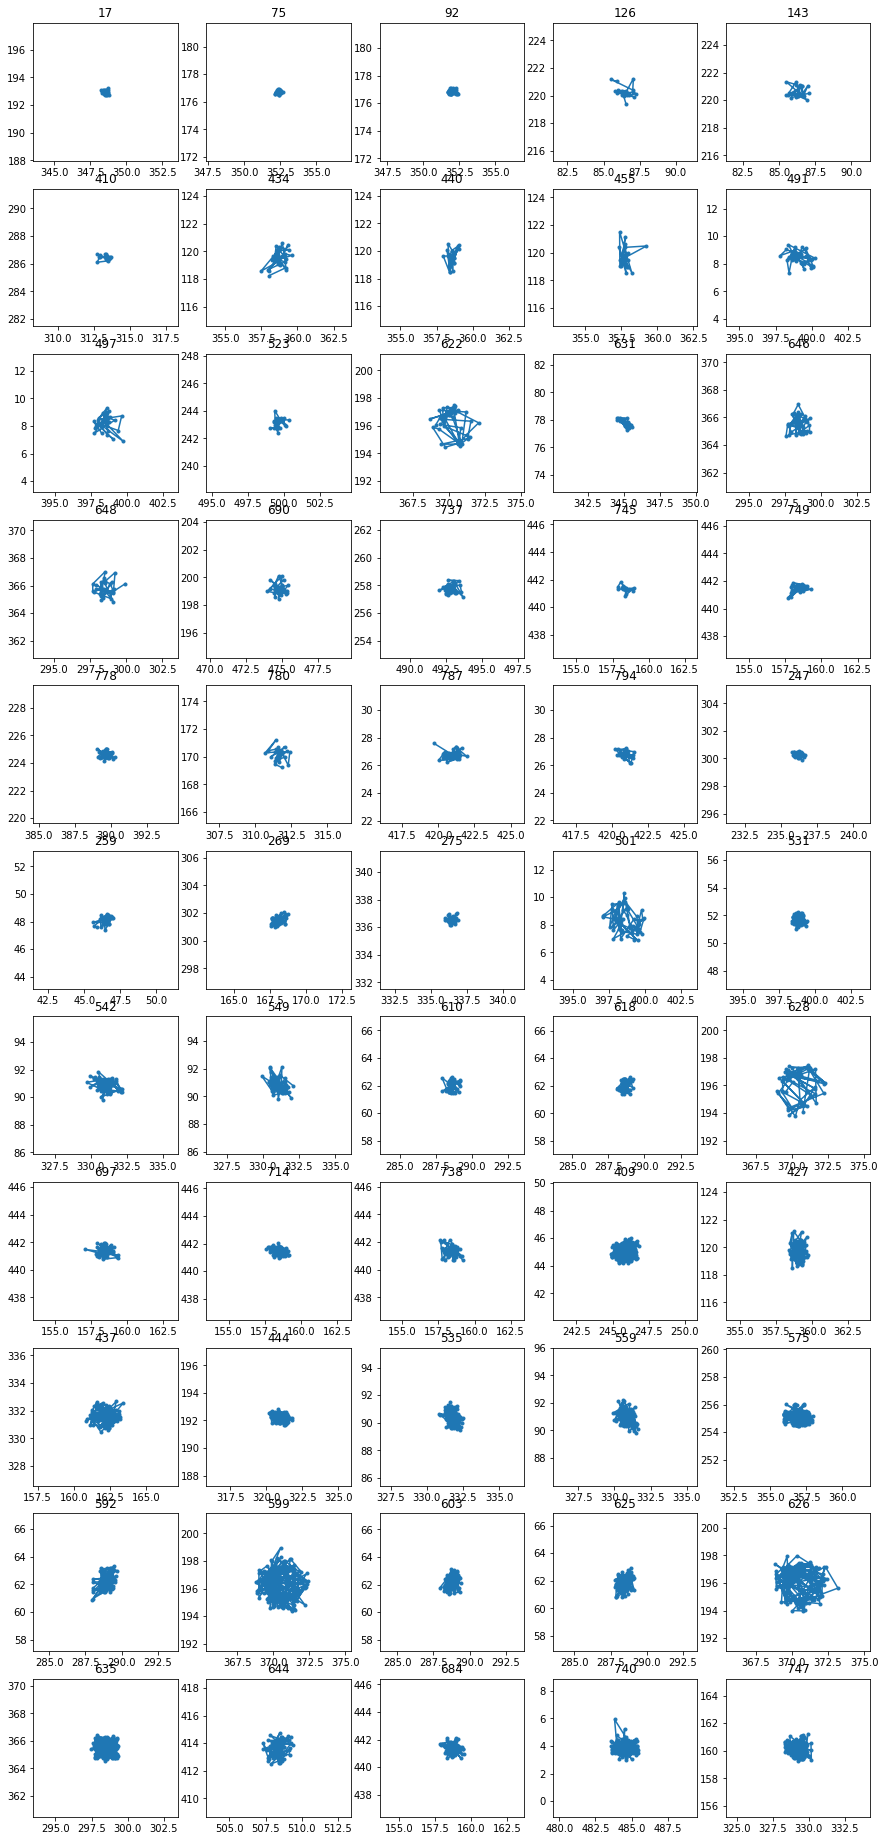

In [53]:
manyplots_real(11, 5, not_pass_ind)